In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
dataset_path = "/content/drive/My Drive/Colab Notebooks/bdos"

In [3]:
!pip3 install finetune
!pip install tqdl
!pip install sentencepiece

     |████████████████████████████████| 143kB 5.9MB/s 
     |████████████████████████████████| 7.0MB 10.5MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 163kB 53.5MB/s 
     |████████████████████████████████| 5.5MB 38.9MB/s 
  Created wheel for finetune: filename=finetune-0.8.6-cp36-none-any.whl size=201589 sha256=30da1900892a2f5ea3cce91c4411ecab88e384e8b5152c734e1bf7523fe0f362
  Stored in directory: /root/.cache/pip/wheels/56/45/03/12e571dd3f3c0d02382be5e3dcb4e1497bae9d5f13ff118bd0
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45613 sha256=9a8a61e2d01fd68f25180564ab7b6bb230dd4bc1df6bbe9f735af910dac9e2aa
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built finetune ftfy
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing 

In [132]:
import pandas as pd 
import nltk
import re
import nltk
from nltk.corpus import stopwords
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score, hamming_loss
from nltk import word_tokenize
from gensim.models import word2vec

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt", "...", "."]
stopwords.extend(other_exclusions)

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [40]:
read_single_class = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bdos/train.csv")
read_multi_class = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bdos/train_multi.csv")

read_multi_class.rename(columns={"Text_Tag": "Tag"}, inplace=True)
read_multi_class

,Labels,Text,Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"
...,...,...,...
10235,3,There are a larger number of shark attacks in ...,"animals,elections"
10236,3,Democrats have now become the party of the [At...,elections
10237,2,Says an alternative to Social Security that op...,"retirement,social-security"
10238,1,On lifting the U.S. Cuban embargo and allowing...,"florida,foreign-policy"


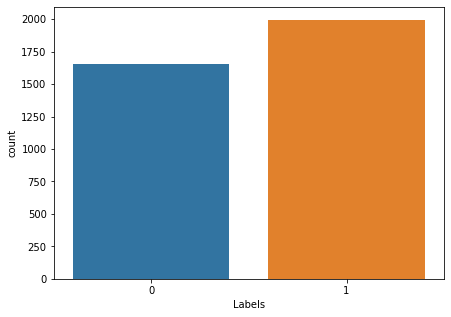

In [47]:
pt = read_multi_class[(read_multi_class.Labels  == 1)|(read_multi_class.Labels  == 0) ]

plt.figure(figsize=(7,5))
sns.countplot(x='Labels',data=pt)

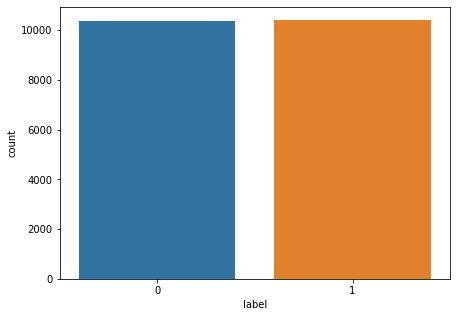

In [42]:
plt.figure(figsize=(7,5))
sns.countplot(x='label',data=read_single_class)

In [51]:
read_single_class.label.replace(0, 5,inplace=True)
read_single_class

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,5
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,5
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,5
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,5
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [52]:
print(len(read_single_class))
print(len(read_multi_class))

# Rename the columns of b.csv that should match the ones in a.csv
bigdata = pd.concat([read_single_class, read_multi_class], ignore_index=True, sort=False)
assert (len(read_single_class) + len(read_multi_class)) == len(bigdata)

bigdata.label.fillna(0,inplace=True)
bigdata.Labels.fillna(0,inplace=True)
bigdata['class'] = bigdata['label'] + bigdata['Labels']

bigdata.columns = bigdata.columns.str.replace('.*?text', 'Text')
s = bigdata.stack()

bigdata = s.unstack()
bigdata.drop(columns=['id', 'label', 'Labels'],inplace=True)

bigdata.fillna("unavailable", inplace=True)
pd.options.display.float_format = '{:,.0f}'.format
# bigdata.dropna(subset=[''] inplace=True)
bigdata

20800
10240


,Tag,Text,author,class,title
0,unavailable,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,unavailable,Ever get the feeling your life circles the rou...,Daniel J. Flynn,5,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,unavailable,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com,1,Why the Truth Might Get You Fired
3,unavailable,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss,1,15 Civilians Killed In Single US Airstrike Hav...
4,unavailable,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy,1,Iranian woman jailed for fictional unpublished...
...,...,...,...,...,...
31035,"animals,elections",There are a larger number of shark attacks in ...,unavailable,3,unavailable
31036,elections,Democrats have now become the party of the [At...,unavailable,3,unavailable
31037,"retirement,social-security",Says an alternative to Social Security that op...,unavailable,2,unavailable
31038,"florida,foreign-policy",On lifting the U.S. Cuban embargo and allowing...,unavailable,1,unavailable


In [53]:
test_single_class = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bdos/test.csv")
test_multi_class = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bdos/test_multi.csv")

test_multi_class.rename(columns={"Text_Tag": "Tag"}, inplace=True)
# Rename the columns of b.csv that should match the ones in a.csv
bigtest = pd.concat([test_single_class, test_multi_class], ignore_index=True, sort=False)
assert (len(test_single_class) + len(test_multi_class)) == len(bigtest)

bigtest.columns = bigtest.columns.str.replace('.*?text', 'Text')
s = bigtest.stack()

bigtest = s.unstack()
bigtest.drop(columns=['id'],inplace=True)
bigtest.fillna("unavailable", inplace=True)

bigtest

,Tag,Text,author,title
0,unavailable,"PALO ALTO, Calif. — After years of scorning...",David Streitfeld,"Specter of Trump Loosens Tongues, if Not Purse..."
1,unavailable,Russian warships ready to strike terrorists ne...,unavailable,Russian warships ready to strike terrorists ne...
2,unavailable,Videos #NoDAPL: Native American Leaders Vow to...,Common Dreams,#NoDAPL: Native American Leaders Vow to Stay A...
3,unavailable,"If at first you don’t succeed, try a different...",Daniel Victor,"Tim Tebow Will Attempt Another Comeback, This ..."
4,unavailable,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,Truth Broadcast Network,Keiser Report: Meme Wars (E995)
...,...,...,...,...
6462,education,Says his budget provides the highest state fun...,unavailable,unavailable
6463,"civil-rights,crime,criminal-justice",Ive been here almost every day.,unavailable,unavailable
6464,"bipartisanship,congress,foreign-policy,history","In the early 1980s, Sen. Edward Kennedy secret...",unavailable,unavailable
6465,"environment,government-efficiency",Says an EPA permit languished under Strickland...,unavailable,unavailable


In [54]:
bigdata.to_csv("/content/drive/My Drive/Colab Notebooks/bdos/final_data.csv")
bigtest.to_csv("/content/drive/My Drive/Colab Notebooks/bdos/final_test.csv")

#**READ CLEANED CSV**

In [56]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bdos/final_data.csv") 
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/bdos/final_test.csv") 
tag_df_ = df.join(df['Tag'].str.split(',', expand=True).add_prefix('Tag'))
tag_df_.fillna("empty tag", inplace=True)
pd.options.display.float_format = '{:,.0f}'.format

tag_df_ = tag_df_.loc[df['class'].isin([1,5])]
tag_df_['class'] = tag_df_['class'].map({5: 1, 1:0})
tag_df_

,Unnamed: 0,Tag,Text,author,class,title,Tag0,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9,Tag10,Tag11,Tag12,Tag13,Tag14,Tag15,Tag16,Tag17,Tag18,Tag19
0,0,unavailable,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,0,House Dem Aide: We Didn’t Even See Comey’s Let...,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
1,1,unavailable,Ever get the feeling your life circles the rou...,Daniel J. Flynn,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
2,2,unavailable,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com,0,Why the Truth Might Get You Fired,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
3,3,unavailable,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss,0,15 Civilians Killed In Single US Airstrike Hav...,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
4,4,unavailable,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy,0,Iranian woman jailed for fictional unpublished...,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31016,31016,"climate-change,environment",There has been no net global warming for over ...,unavailable,0,unavailable,climate-change,environment,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
31018,31018,"elections,states",This race will be the Democrats top target thi...,unavailable,0,unavailable,elections,states,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
31021,31021,"federal-budget,health-care,medicare,message-ma...","As a result of Obamacare, California seniors f...",unavailable,0,unavailable,federal-budget,health-care,medicare,message-machine-2014,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag
31022,31022,federal-budget,"For the first time since the Korean War, total...",unavailable,1,unavailable,federal-budget,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag


#**CLEAN UP**

In [58]:
def clean_text(tweet):
    tweet = tweet.apply(lambda x: ' '.join([re.sub('&#8217;', '\'', word) for word in x.split()]))
    tweet = tweet.apply(lambda x: ' '.join([re.sub('\&', ' &', word) for word in x.split()]))
    tweet = tweet.apply(lambda x: ' '.join([re.sub('@', ' @', word) for word in x.split()]))
    
    tweet = tweet.apply(lambda x: ' '.join([" ".join(re.findall("[#]?[A-Za-z0-9\']+", word.lower())) for word in x.split() if not word.startswith('@') and not word.startswith("&") and not word.startswith("http://") and word.lower() not in stopwords]).strip())
    #[#]?[A-Za-z]+ | [#]?\w+
    
    return tweet
tag_df = tag_df_
tag_df["clean_text"] = clean_text(tag_df.Text)
df_test["clean_text"] = clean_text(df_test.Text)
tag_df

,Unnamed: 0,Tag,Text,author,class,title,Tag0,Tag1,Tag2,Tag3,Tag4,Tag5,Tag6,Tag7,Tag8,Tag9,Tag10,Tag11,Tag12,Tag13,Tag14,Tag15,Tag16,Tag17,Tag18,Tag19,clean_text
0,0,unavailable,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,0,House Dem Aide: We Didn’t Even See Comey’s Let...,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,house dem aide didn t even see comey s letter ...
1,1,unavailable,Ever get the feeling your life circles the rou...,Daniel J. Flynn,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,ever get feeling life circles roundabout rathe...
2,2,unavailable,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com,0,Why the Truth Might Get You Fired,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,truth might get fired october 29 2016 tension ...
3,3,unavailable,Videos 15 Civilians Killed In Single US Airstr...,Jessica Purkiss,0,15 Civilians Killed In Single US Airstrike Hav...,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,videos 15 civilians killed single us airstrike...
4,4,unavailable,Print \nAn Iranian woman has been sentenced to...,Howard Portnoy,0,Iranian woman jailed for fictional unpublished...,unavailable,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,print iranian woman sentenced six years prison...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31016,31016,"climate-change,environment",There has been no net global warming for over ...,unavailable,0,unavailable,climate-change,environment,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,net global warming decade now
31018,31018,"elections,states",This race will be the Democrats top target thi...,unavailable,0,unavailable,elections,states,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,race democrats top target november
31021,31021,"federal-budget,health-care,medicare,message-ma...","As a result of Obamacare, California seniors f...",unavailable,0,unavailable,federal-budget,health-care,medicare,message-machine-2014,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,result obamacare california seniors face benef...
31022,31022,federal-budget,"For the first time since the Korean War, total...",unavailable,1,unavailable,federal-budget,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,empty tag,first time since korean war total federal spen...


# **VISUALIZATION**

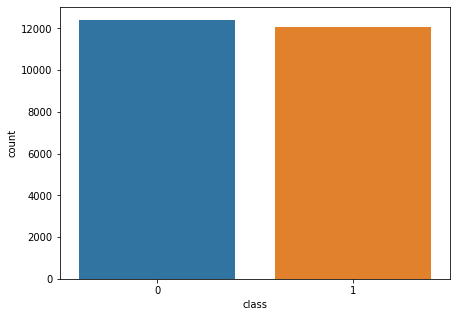

In [6]:
plt.figure(figsize=(7,5))
sns.countplot(x='class',data=tag_df)

False - 0, 
True - 1

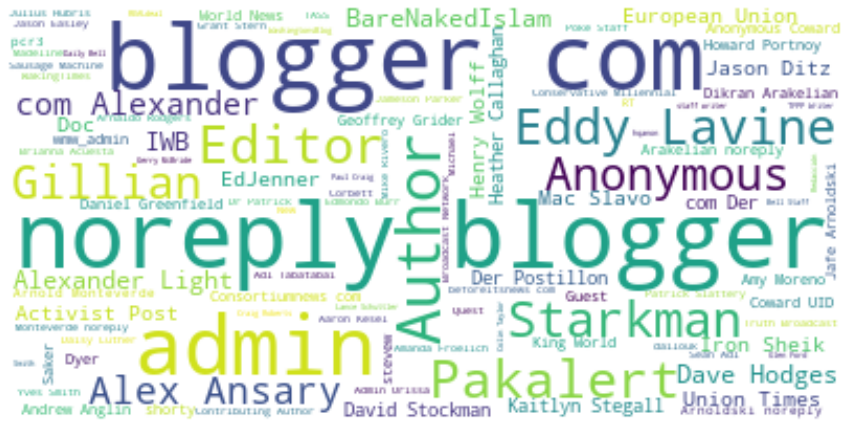

In [67]:
class_0 = tag_df.loc[tag_df['class'] == 0] #false

text = " ".join([x for x in class_0.author if x != "unavailable"])
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words).generate(text)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()
# class_1

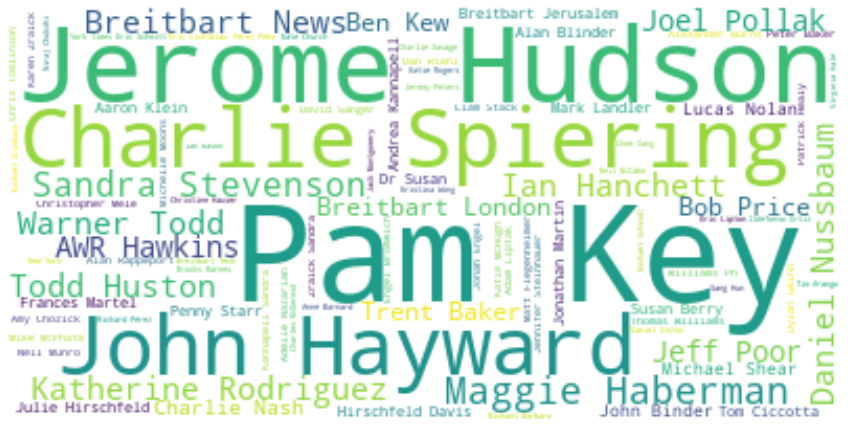

In [69]:
class_1 = tag_df.loc[tag_df['class'] == 1] #true

text = " ".join([x for x in class_1.author if x != "unavailable"])
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words).generate(text)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()
# class_1

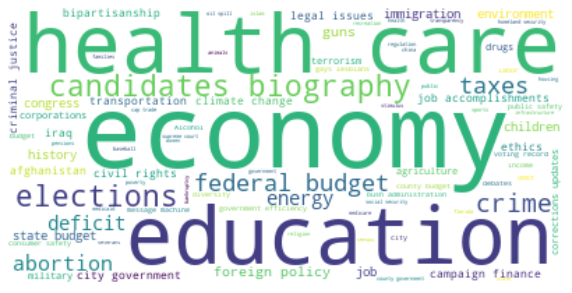

In [11]:
class_1 = tag_df.loc[tag_df['class'] == 1] #true

tag = " ".join([x for x in class_1.Tag0 if x != "unavailable"])
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words).generate(tag)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

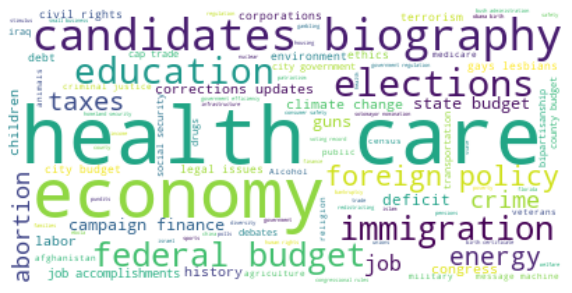

In [12]:
class_0 = tag_df.loc[tag_df['class'] == 0] #false

tag = " ".join([x for x in class_0.Tag0 if x != "unavailable"])
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words).generate(tag)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

1676


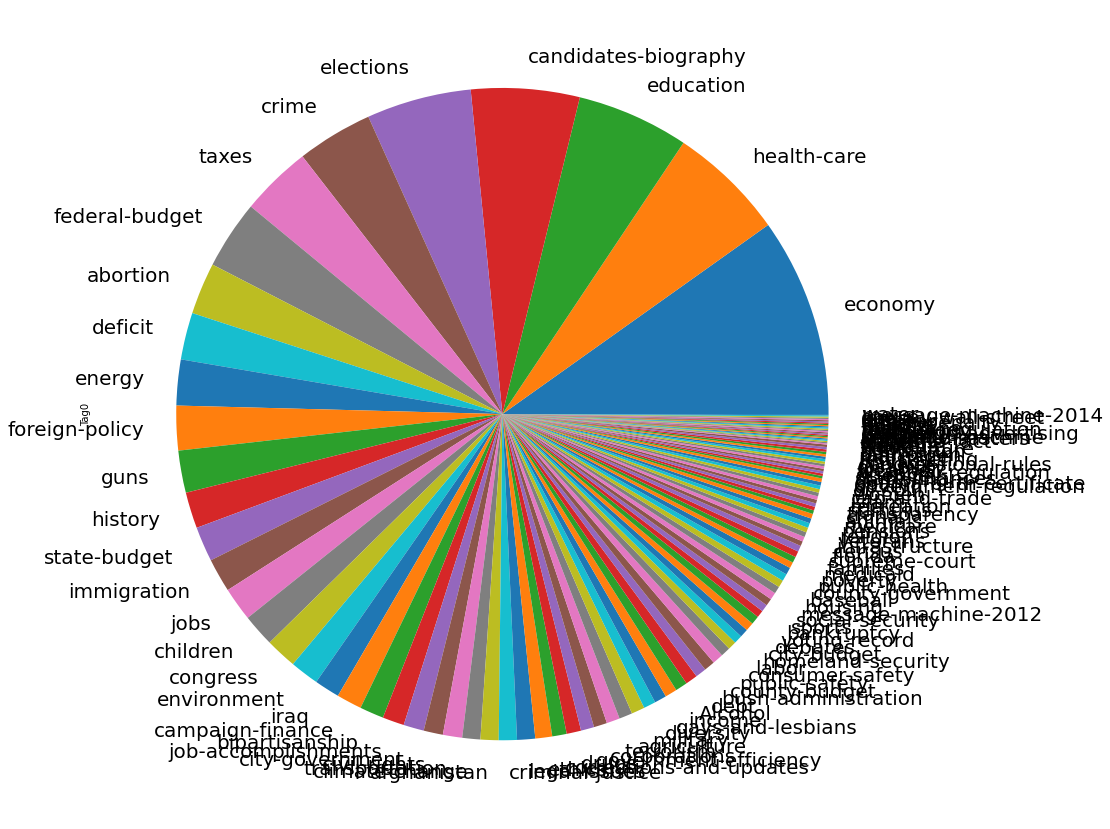

In [13]:
class_1 = tag_df.loc[tag_df['class'] == 1] #true
class_1 = class_1.loc[tag_df['Tag0'] != "unavailable"]

class_1['Tag0'].value_counts().plot(kind="pie", figsize=(15,15), fontsize=20)
print(len(class_1))

1993


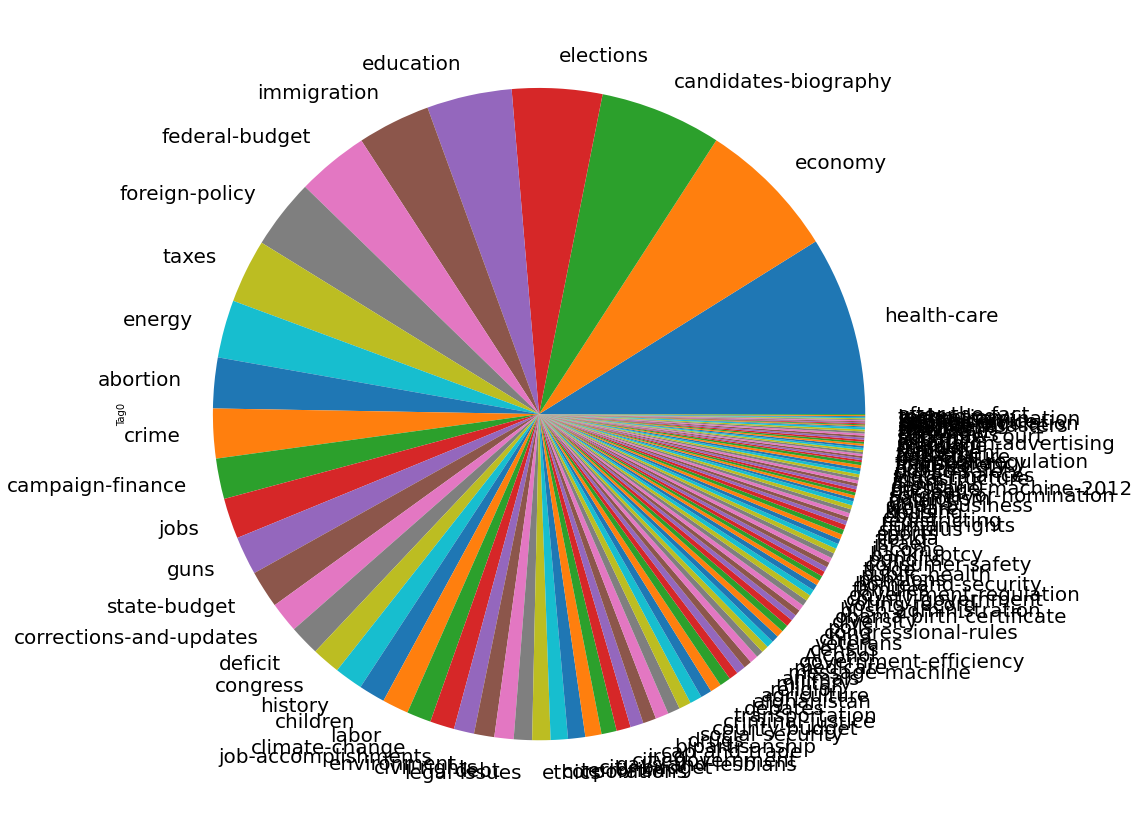

In [14]:
class_0 = tag_df.loc[tag_df['class'] == 0] #false
class_0 = class_0.loc[tag_df['Tag0'] != "unavailable"]

class_0['Tag0'].value_counts().plot(kind="pie", figsize=(15,15), fontsize=20)
print(len(class_0))

# **TRAINING**

### **TFID Vectorizer**

In [115]:
input_labels = ["Text", "author", "title", "Tag0"]

X_train, X_val, y_train, y_val = train_test_split(tag_df["clean_text"], 
                                                    tag_df['class'],
                                                    test_size=0.30,
                                                    train_size= 0.70,
       
                                                    random_state=0)
tfid_count_vect = TfidfVectorizer().fit(X_train)
tfid_vect = TfidfVectorizer()
X_train_counts = tfid_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) 

In [ ]:
lrModel = LogisticRegression()
lrModel.fit(X_train_tfidf, y_train)
pred = lrModel.predict(tfid_vect.transform(X_val))
print('F1 lrModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

In [ ]:
mlModel = MultinomialNB()
mlModel.fit(X_train_tfidf, y_train)
pred = mlModel.predict(tfid_vect.transform(X_val))
print('F1 mlModel :', f1_score(y_val, pred, )) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

In [ ]:
rfcModel = RandomForestClassifier()
rfcModel.fit(X_train_tfidf, y_train)
pred = rfcModel.predict(tfid_vect.transform(X_val))
print('F1 rfcModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

In [ ]:
svcModel = LinearSVC()
svcModel.fit(X_train_tfidf, y_train)
pred = svcModel.predict(tfid_vect.transform(X_val))
print('F1 svcModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

### **Count Vectorizer**

In [116]:
X_train, X_val, y_train, y_val = train_test_split(tag_df["clean_text"], 
                                                    tag_df['class'],
                                                    test_size=0.30,
                                                    train_size= 0.70,
                                                    random_state=0)

count_vect = CountVectorizer().fit(X_train)
X_train_countvec = count_vect.transform(X_train)

In [77]:
lrModel = LogisticRegression()
lrModel.fit(X_train_countvec, y_train)
pred = lrModel.predict(count_vect.transform(X_val))
print('F1 lrModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

F1 lrModel : 0.887814588369117
              precision    recall  f1-score   support

           0      0.867     0.929     0.897      3694
           1      0.922     0.856     0.888      3648

    accuracy                          0.893      7342
   macro avg      0.895     0.892     0.892      7342
weighted avg      0.895     0.893     0.892      7342



In [78]:
mlModel = MultinomialNB()
mlModel.fit(X_train_countvec, y_train)
pred = mlModel.predict(count_vect.transform(X_val))
print('F1 mlModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

F1 mlModel : 0.856632197114771
              precision    recall  f1-score   support

           0      0.907     0.775     0.836      3694
           1      0.802     0.920     0.857      3648

    accuracy                          0.847      7342
   macro avg      0.854     0.847     0.846      7342
weighted avg      0.855     0.847     0.846      7342



In [79]:
rfcModel = RandomForestClassifier()
rfcModel.fit(X_train_countvec, y_train)
pred = rfcModel.predict(count_vect.transform(X_val))
print('F1 rfcModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

F1 rfcModel : 0.8568579974362627
              precision    recall  f1-score   support

           0      0.839     0.901     0.869      3694
           1      0.892     0.825     0.857      3648

    accuracy                          0.863      7342
   macro avg      0.865     0.863     0.863      7342
weighted avg      0.865     0.863     0.863      7342



In [87]:
svcModel = LinearSVC()
svcModel.fit(X_train_countvec, y_train)
pred = svcModel.predict(count_vect.transform(X_val))
print('F1 svcModel :', f1_score(y_val, pred)) #will return the total ratio of tp/(tp + fp)
print(metrics.classification_report(y_val, pred, digits=3))

F1 svcModel : 0.88236824465856
              precision    recall  f1-score   support

           0      0.827     0.857     0.842      3694
           1      0.850     0.818     0.834      3648

    accuracy                          0.838      7342
   macro avg      0.838     0.838     0.838      7342
weighted avg      0.838     0.838     0.838      7342



**The best performer on both datasets is SVM with features from TFIDVectorizer**

So we do a parameter search on it to try to improve it further

In [ ]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LinearSVC()),
])

parameters = {
    'tfidf__max_df': [0.25, 0.5, 0.75, 1.0],
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'model__C': [0.01, 0.1, 1, 10, 50, 100]
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1', return_train_score=True)


print("Performing grid search on data 1...")
grid_search.fit(X_train, y_train)

In [61]:
tfid_vect_data = TfidfVectorizer(max_df=0.75, ngram_range=(1, 2)).fit(X_train)
tfid_vectorized_data = tfid_vect_data.transform(X_train)

model = LinearSVC(C=0.1)
model.fit(tfid_vectorized_data, y_train)
pred = model.predict(tfid_vect_data.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.9040283058724122


In [94]:
pipeline = Pipeline([
    ('tfidf', CountVectorizer()),
    ('model', LogisticRegression()),
])

parameters = {
    'tfidf__max_df': [0.25, 0.75, 1.0],
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'model__C': [0.01, 0.1, 1, 10, 50]
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='f1', return_train_score=True)


print("Performing grid search on data 1...")
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_, "Best score:", grid_search.best_score_)

Performing grid search on data 1...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 112.0min finished


Best parameters: {'model__C': 0.1, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)} Best score: 0.8927135040582262


In [118]:
vect_data = CountVectorizer(max_df=0.75, ngram_range=(1, 2)).fit(X_train)
vectorized_data = vect_data.transform(X_train)

model = LogisticRegression(C=0.1)
model.fit(vectorized_data, y_train)
pred = model.predict(vect_data.transform(X_val))
print('F1 :', f1_score(y_val, pred)) 

F1 : 0.8821055539400989


### **PreCleaned TFID Vectorizer**

In [117]:
X_train, X_val, y_train, y_val = train_test_split(tag_df_["Text"], 
                                                    tag_df_['class'],
                                                    test_size=0.30,
                                                    train_size= 0.70,
       
                                                    random_state=0)
tfid_count_vect = TfidfVectorizer().fit(X_train)
tfid_vect = TfidfVectorizer()
X_train_counts = tfid_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts) 

tfid_vect_data = TfidfVectorizer(max_df=0.75, ngram_range=(1, 2)).fit(X_train)
tfid_vectorized_data = tfid_vect_data.transform(X_train)

model = LinearSVC(C=1)
model.fit(tfid_vectorized_data, y_train)
pred = model.predict(tfid_vect_data.transform(X_val))
print('F1 :', f1_score(y_val, pred))

## **SVC with Glove Emeddings**

In [120]:
data = tag_df["Text"].map(word_tokenize).values
total_vocabulary = set(word for text in data for word in tag_df["Text"])

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 24048 unique tokens in the dataset.


In [121]:
glove = {}
with open('/content/drive/My Drive/Colab Notebooks/bdos/glove.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [122]:
class W2vVectorizer(object):

    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])

    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [124]:
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', LinearSVC())])

lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [125]:
models = [('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [144]:
from sklearn.model_selection import cross_val_score

scoring = {'f1_micro': 'f1_micro',
           'f1_macro': 'f1_macro'}

scores = [(name, cross_validate(model, data, tag_df['class'], cv=2, scoring=scoring)) for name, model, in models]

In [145]:
scores

[('Support Vector Machine',
  {'fit_time': array([1.06279325, 1.58110809]),
   'score_time': array([1.05317068, 0.73390293]),
   'test_f1_macro': array([0.88934374, 0.87518409 ]),
   'test_f1_micro': array([0.81089898, 0.86082958 ])}),
 ('Logistic Regression',
  {'fit_time': array([0.8063271 , 1.02205586]),
   'score_time': array([1.01505804, 0.79162073]),
   'test_f1_macro': array([0.84374375, 0.8418409 ]),
   'test_f1_micro': array([0.80898987, 0.8408287 ])})]

#**Deep Learning Models**

In [15]:
from tensorflow.keras.callbacks import TensorBoard
import os
import tensorflow as tf
from keras import backend as K
from tensorflow.python.eager import context
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Dense 

### **Count Vectorizer with BiLSMT with no pretrained vectors**

In [16]:
# vocab_count_vec = {k: v+1 for v, k in enumerate(count_vect.get_feature_names())}
# vocab_count_vec['UNK'] = 0


vocab_tfid_vec = {k: v+1 for v, k in enumerate(tfid_count_vect.get_feature_names())}
vocab_tfid_vec['UNK'] = 0

In [17]:
def make_X(sentences, vocab):
    """
    :param sentences; List of sentences
    :param unigrams_vocab; Unigram vocabulary
    :param bigrams_vocab; Bigram vocabulary
    :return X; Matrix storing all sentences' feature vector 
    """
    X1 = []
    for sentence in sentences:
        x_temp = []
        for word in sentence.split():
            if word in vocab:
                x_temp.append(vocab[word])
            else:
                x_temp.append(vocab["UNK"])

        X1.append(np.array(x_temp))

    X1 = np.array(X1)
    return X1

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def create_keras_model(vocab_size, y_size=1, embedding_size=256, hidden_size=64):
    print("Creating KERAS model")
    
    model = tf.keras.models.Sequential() 
    model.add(Embedding(vocab_size, embedding_size, mask_zero=True)) #tf.keras.layers
    
    model.add(Bidirectional(LSTM(hidden_size, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), merge_mode='concat'))
    
    model.add(Dense(y_size, activation='sigmoid'))
    #model.add(TimeDistributed(Dense(y_size, activation='softmax')))
    #optimizer = K.optimizers.Adam(lr=0.01)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc', f1_m])

    return model

In [18]:
# X = make_X(X_train, vocab_count_vec)
# X_val_ = make_X(X_val, vocab_count_vec)

X = make_X(X_train, vocab_tfid_vec)
X_val_ = make_X(X_val, vocab_tfid_vec)

In [19]:
X_train_ = pad_sequences(X, truncating='post', padding='post', maxlen=1)
X_val_ = pad_sequences(X_val_, truncating='post', padding='post', maxlen=1)

y_train = np.array(y_train)
y_val_ = np.array(y_val)

y_train = y_train.reshape((*y_train.shape, 1, 1))
y_val_ = y_val_.reshape((*y_val_.shape, 1, 1))

In [20]:
print(X_train_.shape)
print(y_train.shape)

print(X_val_.shape)
print(y_val_.shape)

(17129, 1)
(17129, 1, 1)
(7342, 1)
(7342, 1, 1)


In [21]:
batch_size = 128
epochs = 5
model = create_keras_model(len(vocab_tfid_vec))
model.summary()
model.fit(X_train_, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(X_val_, y_val_))

Creating KERAS model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         32456704  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         164352    
_________________________________________________________________
dense (Dense)                (None, None, 1)           129       
Total params: 32,621,185
Trainable params: 32,621,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
134/134 [==============================] - 52s 340ms/step - loss: 0.6083 - acc: 0.6557 - f1_m: 0.6341 - val_loss: 0.5115 - val_acc: 0.7442 - val_f1_m: 0.7756
Epoch 2/5
134/134 [==============================] - 44s 330ms/step - loss: 0.3914 - acc: 0.8377 - f1_m: 0.8185 - val_loss: 0.5059 - val_acc: 0.7408 - val_f1_m: 0.8375
Epoch 3/5
134/134

In [22]:
loss_acc = model.evaluate(X_val_, y_val_, verbose=0)
print("Test data: loss = %0.6f,  accuracy = %0.2f%%, f1_score = %0.2f%%" % (loss_acc[0], loss_acc[1]*100, loss_acc[2]*100))

Test data: loss = 0.411452,  accuracy = 96.55%, f1_score = 93.64%


### **Bi-LSTMs with GloVe pretrained embedding vectors**

In [26]:
embeddings_dict = {}
with open("/content/drive/My Drive/Colab Notebooks/bdos/glove.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [27]:
def make_GloVe_X(sentences, embeddings, no_of_words, embedding_size):
    X1 = []
    for sentence in sentences:
        x_temp = []
        word_count = 0
        for word in sentence.split():
            word_count += 1
            if word_count <= no_of_words:
                if word in embeddings:
                    x_temp.append(embeddings[word])
                else:
                    x_temp.append(np.random.normal(size=embedding_size))
            else:
                break
        if word_count < no_of_words:
            for _ in range(no_of_words - word_count):
                 x_temp.append(np.random.normal(size=embedding_size))

        X1.append(np.array(x_temp))

    X1 = np.array(X1)
    return X1

def create_keras_GloVe_model(y_size=1, embedding_size=50, hidden_size=128):
    print("Creating KERAS model")
    
    model = tf.keras.models.Sequential() 
    #model.add(Embedding(2000, embedding_size, mask_zero=True)) #tf.keras.layers
    
    model.add(Bidirectional(LSTM(hidden_size, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), merge_mode='concat', input_shape=(None, embedding_size)))
    model.add(Bidirectional(LSTM(hidden_size, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), merge_mode='concat'))
    model.add(Bidirectional(LSTM(hidden_size, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), merge_mode='concat'))
    model.add(Bidirectional(LSTM(hidden_size, dropout=0.4, recurrent_dropout=0.4, return_sequences=True), merge_mode='concat'))
    
    model.add(Dense(y_size, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc', f1_m])
    return model

In [28]:
GloVe_X = make_GloVe_X(X_train, embeddings_dict, 1, 50)
GloVe_X_val = make_GloVe_X(X_val, embeddings_dict, 1, 50)
GloVe_X.shape

(17129, 1, 50)

In [29]:
batch_size = 128
epochs = 5
model = create_keras_GloVe_model()
model.summary()
model.fit(GloVe_X, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(GloVe_X_val, y_val_))

Creating KERAS model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 256)         183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 256)         394240    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           257       
Total params: 1,366,273
Trainable params: 1,366,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
134/134 [==============================] - 33s 93ms/step - loss: 0.6540 - acc: 

In [33]:
loss_acc = model.evaluate(GloVe_X_val, y_val, verbose=0)
print("Test data: loss = %0.6f,  accuracy = %0.2f%%, f1_score = %0.2f%%" % (loss_acc[0], loss_acc[1]*100, loss_acc[2]*100))

Test data: loss = 0.421303,  accuracy = 96.55%, f1_score = 94.74%
